# Introverts vs Extroverts 

Authors: Manuel, Alan, Fausto

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Ignoring Warnings on lightGBM training
import warnings
warnings.filterwarnings('ignore')



Dataset has been downloaded from here https://www.kaggle.com/competitions/playground-series-s5e7/data into data directory.


In [2]:
train_path = './data/train.csv'
test_path = './data/test.csv'

# Loading as a Pandas' Data Frame
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

print('Train shape:', df_train.shape)
print('Test shape:', df_test.shape)

Train shape: (18524, 9)
Test shape: (6175, 8)


## 2) Exploraty Data Analysis

Exploring dataset. Looking for null values, info about columns, etc.

In [3]:
# General Information about data.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [4]:
# Describe statistic per column.
df_train.describe(include='all')


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
count,18524.000000,17334.000000,16631,17344.000000,17058.000000,17375,17470.000000,17260.000000,18524
unique,NaN,NaN,2,NaN,NaN,2,NaN,NaN,2
top,NaN,NaN,No,NaN,NaN,No,NaN,NaN,Extrovert
freq,NaN,NaN,12609,NaN,NaN,13313,NaN,NaN,13699
mean,9261.500000,3.137764,NaN,5.265106,4.044319,NaN,7.996737,4.982097,NaN
std,5347.562529,3.003786,NaN,2.753359,2.062580,NaN,4.223484,2.879139,NaN
min,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN
25%,4630.750000,1.000000,NaN,3.000000,3.000000,NaN,5.000000,3.000000,NaN
50%,9261.500000,2.000000,NaN,5.000000,4.000000,NaN,8.000000,5.000000,NaN
75%,13892.250000,4.000000,NaN,8.000000,6.000000,NaN,12.000000,7.000000,NaN


In [5]:
# Number of null values per column
df_train.isna().sum()

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

In [6]:
# Proportion of null values per column
df_train.isna().sum() / len(df_train)

id                           0.000000
Time_spent_Alone             0.064241
Stage_fear                   0.102192
Social_event_attendance      0.063701
Going_outside                0.079141
Drained_after_socializing    0.062028
Friends_circle_size          0.056899
Post_frequency               0.068236
Personality                  0.000000
dtype: float64

The proportion of null values are small enough to impute.

In [7]:
df_train.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


### Distributions per Class (Introvert vs Extovert)

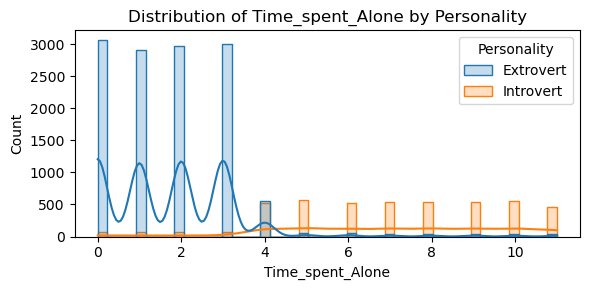

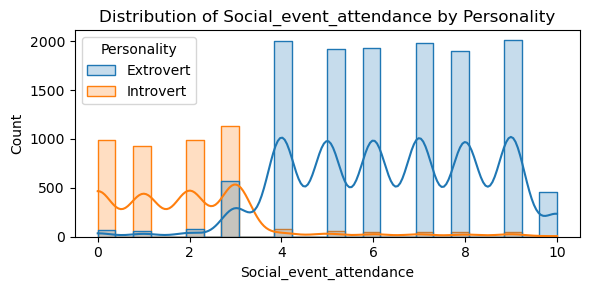

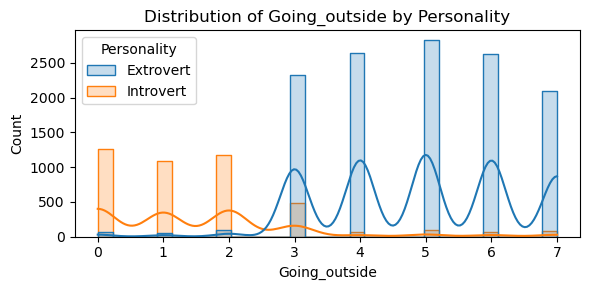

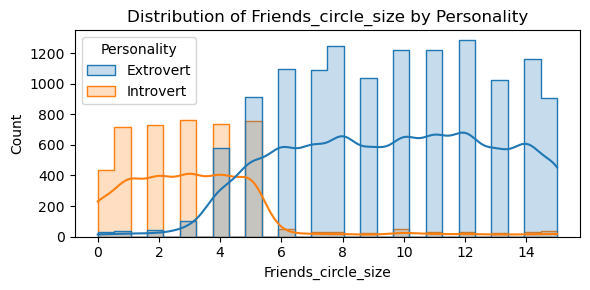

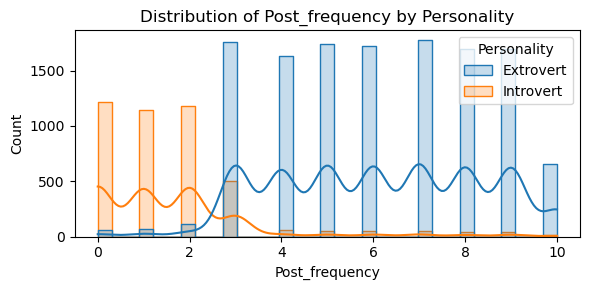

In [8]:
# Numerical cols
numerical_cols = df_train.drop('id', axis=1).select_dtypes(include='number').columns.tolist()

for col in numerical_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(data=df_train, x=col, hue='Personality', kde=True, element='step')
    plt.title(f'Distribution of {col} by Personality')
    plt.tight_layout()
    plt.show()



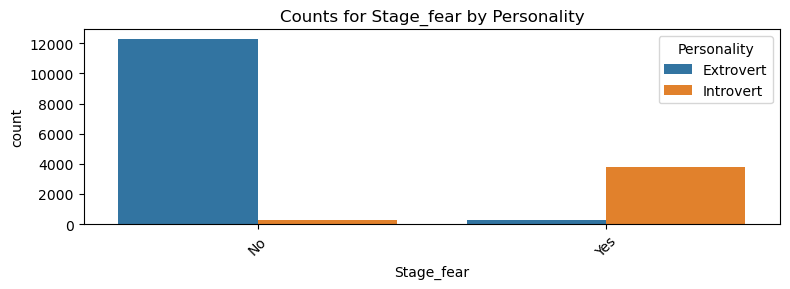

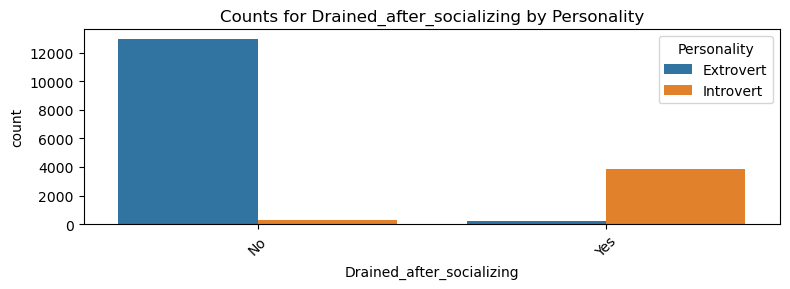

In [9]:
# Categorical cols
cat_cols = df_train.drop(['id', 'Personality'], axis=1).select_dtypes(include='object').columns.tolist()

for col in cat_cols:
    plt.figure(figsize=(8,3))
    sns.countplot(data=df_train, x=col, hue='Personality')
    plt.title(f'Counts for {col} by Personality')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Seems that the classes are clealy separated between them.

### Pearson Correlation Matrix

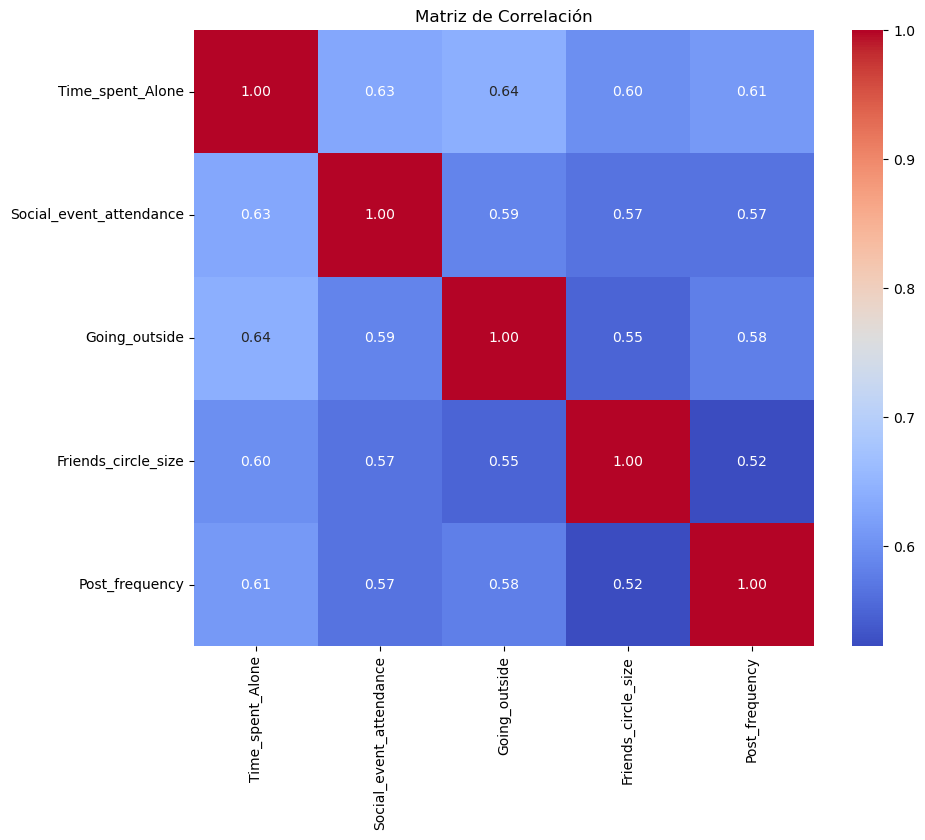

In [10]:
corr_matrix = df_train.drop('id', axis=1).select_dtypes(include='number').corr().abs()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

The features are correlated between them, but not enough to drop some of them. There is not correlation between two features greater than 0.7

## 3) Preprocessing

Defining the preprocessing pipeline for numerical and categorical features.

In [11]:
# Pipelines de preprocesamiento
num_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, cat_cols)
])

In [12]:
# Mapping Introvert and Extrovert to 0 and 1.
le = LabelEncoder()
df_train['Personality_encoded'] = le.fit_transform(df_train['Personality'])

In [13]:
# Spliting Dataset
X = df_train.drop(['Personality','Personality_encoded','id'], axis=1)
y = df_train['Personality_encoded']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## 4) t-SNE
Applyng t-SNE on preprocessed data for visualize the gap between classes.

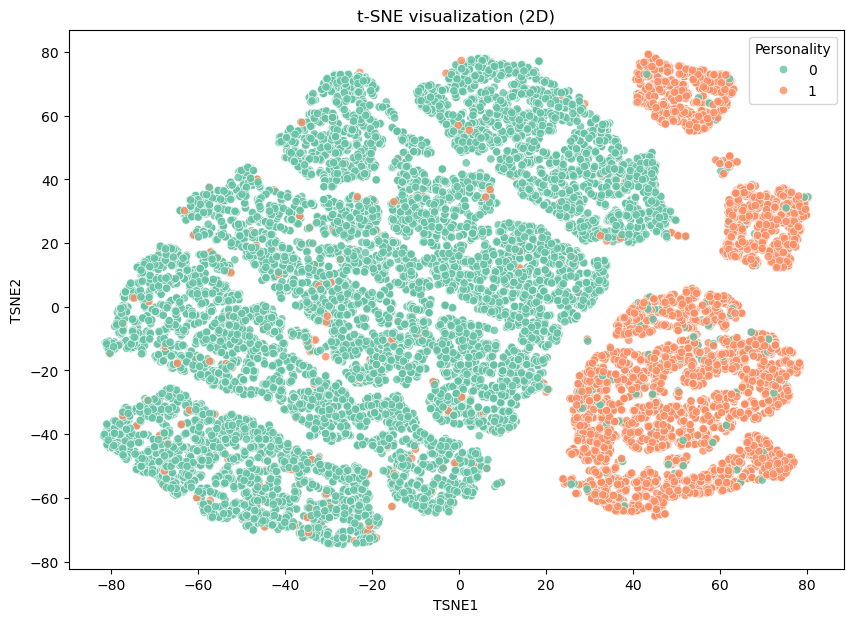

In [14]:
# Preprocessing Data
X_processed = preprocessor.fit_transform(X)

# Applyng t-SNE on preprocessed Data.
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_processed)

# Converting into Data Frame
tsne_df = pd.DataFrame({'TSNE1': X_tsne[:,0], 'TSNE2': X_tsne[:,1], 'Personality': y})

# Ploting
plt.figure(figsize=(10,7))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Personality', palette='Set2', alpha=0.8)
plt.title('t-SNE visualization (2D)')
plt.legend(title='Personality')
plt.show()

We can visualize the obviusly separation between the classes. There is some points that are noise, but they are a few.

## 5) Base Line Model (SVM)

Training a simple SVM to watch the results on data.

In [15]:
# Baseline pipeline
baseline = Pipeline([
    ('preprocessor', preprocessor),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced'))
])

baseline.fit(X_train, y_train)

# Evaluating
train_preds = baseline.predict(X_train)
val_preds = baseline.predict(X_val)

print('Train accuracy:', accuracy_score(y_train, train_preds))
print('\nTrain classification report:\n', classification_report(y_train, train_preds))
print('\nValidation accuracy:', accuracy_score(y_val, val_preds))
print('\nValidation classification report:\n', classification_report(y_val, val_preds))



Train accuracy: 0.9686213644645387

Train classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     10959
           1       0.94      0.93      0.94      3860

    accuracy                           0.97     14819
   macro avg       0.96      0.96      0.96     14819
weighted avg       0.97      0.97      0.97     14819


Validation accuracy: 0.9711201079622133

Validation classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2740
           1       0.94      0.95      0.94       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705



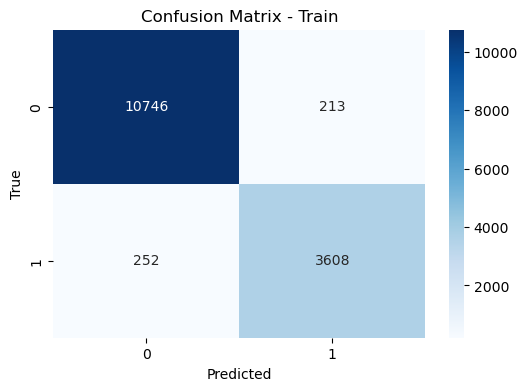

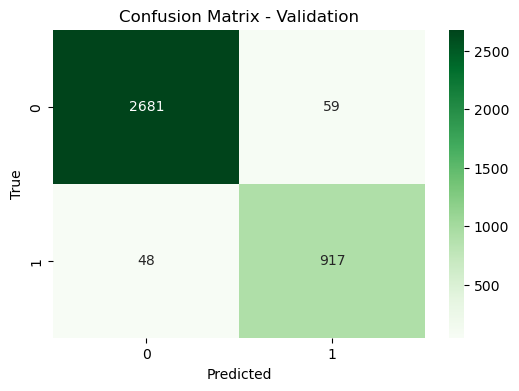

In [16]:
# Confusion Matrix
cm_train = confusion_matrix(y_train, train_preds)
cm_val = confusion_matrix(y_val, val_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

plt.figure(figsize=(6,4))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Validation')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

The results are very good. So lets look for a best model.

## 6) Looking for best Model (GridSearchCV)

In [17]:
# Pipelines 
pipelines = {
    'svm': Pipeline([('preprocessor', preprocessor), ('clf', SVC())]),
    'svm_linear': Pipeline([('preprocessor', preprocessor), ('clf', LinearSVC(max_iter=5000))]),
    'rf': Pipeline([('preprocessor', preprocessor), ('clf', RandomForestClassifier())]),
    'gb': Pipeline([('preprocessor', preprocessor), ('clf', GradientBoostingClassifier())]),
    'logreg': Pipeline([('preprocessor', preprocessor), ('clf', LogisticRegression(max_iter=1000))]),
    'xgb': Pipeline([('preprocessor', preprocessor), ('clf', XGBClassifier(objective='binary:logistic', eval_metric='logloss', tree_method='hist'))]),
    'cat': Pipeline([('preprocessor', preprocessor), ('clf', CatBoostClassifier(verbose=0))]),
    'lgb': Pipeline([('preprocessor', preprocessor), ('clf', LGBMClassifier(verbose=0))]),
    'mlp': Pipeline([('preprocessor', preprocessor), ('clf', MLPClassifier(max_iter=1000))])
}

param_grids = {
    'svm': {'clf__kernel': ['rbf'], 'clf__C': [0.1,1,10], 'clf__gamma': ['scale','auto']},
    'svm_linear': {'clf__C': [0.01,0.1,1]},
    'rf': {'clf__n_estimators': [100,300], 'clf__max_depth': [None,10]},
    'gb': {'clf__n_estimators': [100,300], 'clf__learning_rate': [0.1,0.01], 'clf__max_depth': [2,3]},
    'logreg': {'clf__C': [0.1,1,10]},
    'xgb': {'clf__n_estimators': [200,400], 'clf__learning_rate': [0.05,0.1], 'clf__max_depth': [3,5]},
    'cat': {'clf__depth': [4,6], 'clf__learning_rate': [0.01,0.05], 'clf__iterations': [200,400]},
    'lgb': {'clf__n_estimators': [200,400], 'clf__learning_rate': [0.05,0.1]},
    'mlp': {'clf__hidden_layer_sizes': [(64,),(128,)], 'clf__alpha': [1e-4,1e-3]}
}

results = {}
for name, pipe in pipelines.items():
    print(f'Training {name}...')
    try:
        grid = GridSearchCV(pipe, param_grids[name], scoring='f1_macro', cv=5, n_jobs=-1)
        grid.fit(X_train, y_train)
        results[name] = grid
        print(f'  Best score for {name}:', grid.best_score_)
    except Exception as e:
        print(f'  Skipped {name} due to error:', e)

# Choosing the best model based on accuracy on train.
best_model_name = max(results, key=lambda name: results[name].best_score_)
best_model = results[best_model_name]
print('\nBest Model:', best_model_name)
print('Best CV score:', best_model.best_score_)
print('Best hyperparameters:', best_model.best_params_)


Training svm...


  Best score for svm: 0.9587621012513502
Training svm_linear...
  Best score for svm_linear: 0.958289690318099
Training rf...
  Best score for rf: 0.9578290113331402
Training gb...
  Best score for gb: 0.9582279120769026
Training logreg...
  Best score for logreg: 0.9584582551605919
Training xgb...
  Best score for xgb: 0.958418100353212
Training cat...
  Best score for cat: 0.9586619321410413
Training lgb...
  Best score for lgb: 0.9577640715177236
Training mlp...
  Best score for mlp: 0.9589169528694212

Best Model: mlp
Best CV score: 0.9589169528694212
Best hyperparameters: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (64,)}


## 7) Final Evaluation and Generate the CSV for submission

In [18]:
try:
    model_to_use = best_model.best_estimator_
except NameError:
    model_to_use = baseline

# Train the model with all the data.
X_full = df_train.drop(['Personality','Personality_encoded','id'], axis=1)
y_full = df_train['Personality_encoded']

model_to_use.fit(X_full, y_full)
X_test = df_test.drop(['id'], axis=1)

test_preds = model_to_use.predict(X_test)

# Transforming 0, 1 into Introvert and Extrovert
test_preds_labels = le.inverse_transform(test_preds)

submission = pd.DataFrame({'id': df_test['id'], 'Personality': test_preds_labels})
submission.to_csv('submission.csv', index=False)